In [267]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls")

source("script/packages.R"  )
source("script/input_data.R")
source("script/functions.R" )


In [268]:
library(gameofthrones)
library(colorspace)
library(corrplot)

In [269]:
covariates = fread("pipeline/3.1.covariates//covariates.txt", sep = "\t", header = TRUE, data.table = FALSE)

In [270]:
eqtl_genes    = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.gene.egenes.txt"         , sep = "\t", header = TRUE, data.table = FALSE)
int_genes     = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.gene.interactions.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
fm_genes      = fread("pipeline/3.2.eqtls/eqtls_fine_map//cardiac_eqtls.gene.txt"      , sep = "\t", header = TRUE, data.table = FALSE)
eqtl_isoforms = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.isoform.egenes.txt"      , sep = "\t", header = TRUE, data.table = FALSE)
int_isoforms  = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.isoform.interactions.txt", sep = "\t", header = TRUE, data.table = FALSE)
fm_isoforms   = fread("pipeline/3.2.eqtls/eqtls_fine_map//cardiac_eqtls.isoform.txt"   , sep = "\t", header = TRUE, data.table = FALSE)


# Correlation between CIBERSORT cell types

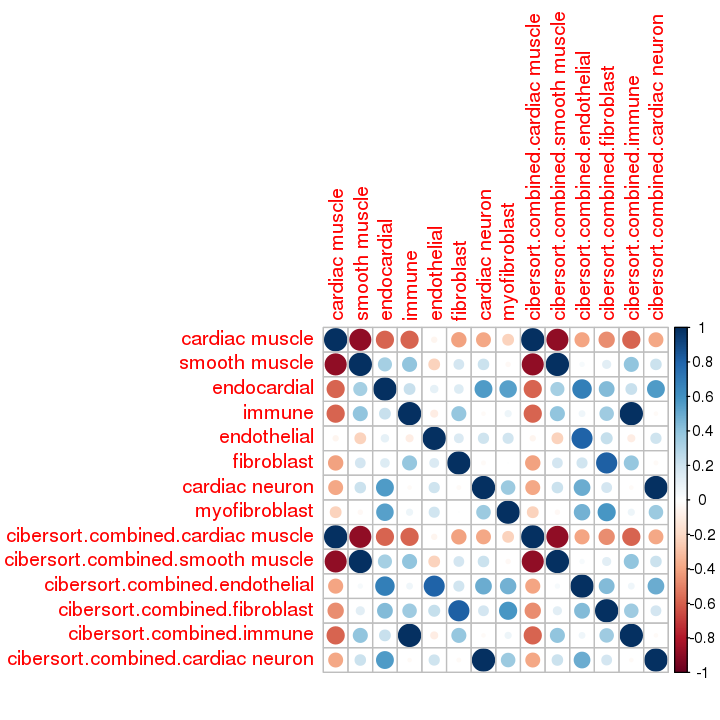

In [271]:
cordata = cor(covariates[, grepl("cibersort", colnames(covariates))])

rownames(cordata) = gsub("_", " ", gsub("cibersort.regular\\.", "", rownames(cordata)))
colnames(cordata) = gsub("_", " ", gsub("cibersort.regular\\.", "", colnames(cordata)))

options(repr.plot.width = 6, repr.plot.height = 6)
corrplot(cordata)

# Some numbers

In [272]:
eqtl_numbers = function(name, egenes)
{
    mycond = paste(unlist(lapply(1:max(egenes$type), function(type)
                  {
                      paste("Conditional ", type, " = ", nrow(egenes[egenes$type == type & egenes$egene == TRUE,]), sep = "")
                  })), collapse = "\n")

    message(paste("####################################################",
                  name,
                  paste("Tested isoforms", length(unique(egenes$transcript_id)), sep = " = "),
                  paste("Tested genes"   , length(unique(egenes$gene_id      )), sep = " = "),
                  paste("eGenes"         , nrow(egenes[egenes$type == 0 & egenes$egene == TRUE,]), sep = " = "),
                  paste("eGenes (%)"     , signif(100 * nrow(egenes[egenes$type == 0 & egenes$egene == TRUE,]) / nrow(egenes[egenes$type == 0,]), digits = 3), sep = " = "),
                  mycond,
                  sep = "\n"
                 )
            )
}

eqtl_numbers("Genes"   , eqtl_genes   )
eqtl_numbers("Isoforms", eqtl_isoforms)


####################################################
Genes
Tested isoforms = 19823
Tested genes = 19823
eGenes = 11756
eGenes (%) = 59.3
Conditional 1 = 4408
Conditional 2 = 1319
Conditional 3 = 396
Conditional 4 = 161
Conditional 5 = 74

####################################################
Isoforms
Tested isoforms = 43454
Tested genes = 14590
eGenes = 8129
eGenes (%) = 18.7
Conditional 1 = 1120
Conditional 2 = 270
Conditional 3 = 78
Conditional 4 = 26
Conditional 5 = 10



# Distance from TSS

Genes 1: p = 4.09e-145

Genes 2: p = 3.43e-11

Genes 3: p = 4.24e-05

Genes 4: p = 0.559

Genes 5: p = 0.252

Isoforms 1: p = 5.24e-15

Isoforms 2: p = 3.48e-06

Isoforms 3: p = 0.704

Isoforms 4: p = 0.117

Isoforms 5: p = 0.582



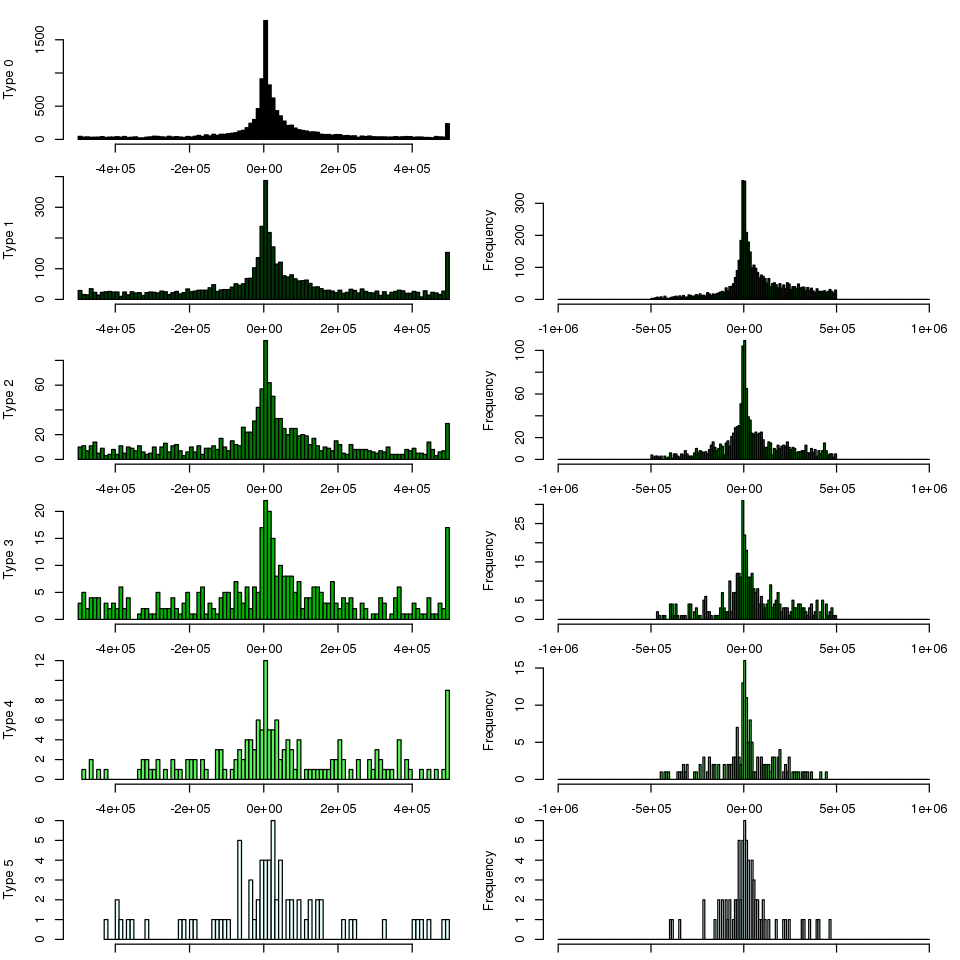

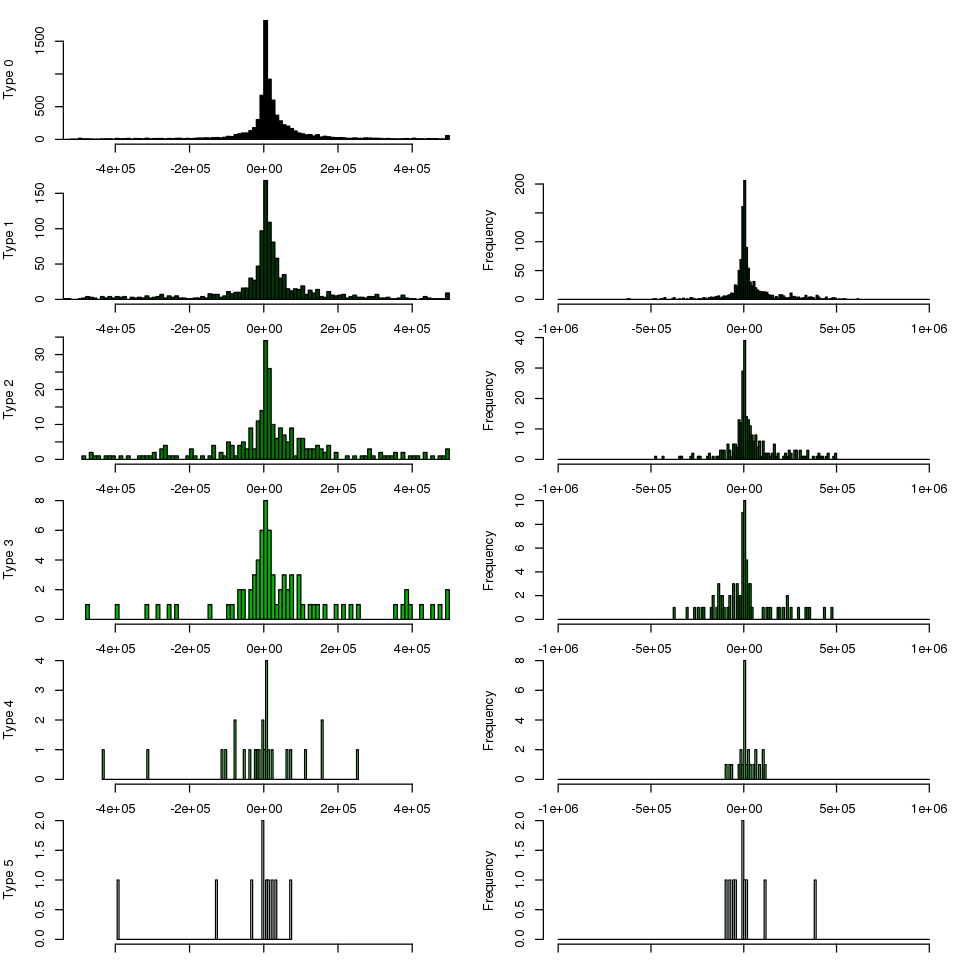

In [273]:
eqtl_distance = function(name, egenes)
{
    egenes          = egenes[egenes$egene == TRUE,]
    egenes$distance = unlist(lapply(egenes$distance, function(x){min(x, 500000)}))
    
    type2col = data.frame(type = sort(unique(egenes$type)), color = got(length(unique(egenes$type)), option = "Wildfire"))
    
    options(repr.plot.width = 8, repr.plot.height = 8)
    layout(matrix(1:(length(unique(egenes$type)) * 2), ncol = 2, byrow = FALSE))
    
    par(mar = c(1,4,1,1))
    
    egene2type = lapply(type2col$type, function(type)
    {
        this = egenes[egenes$type == type,]
        hist(egenes[egenes$type == type, "distance"], breaks = 100, col = type2col[type2col$type == type, "color"], xlim = c(-1,1) * 500000, ylab = paste("Type", type), main = "")
        
        rownames(this) = this$transcript_id
        return(this)
    })
    
    names(egene2type) = paste("type", type2col$type)
    
    plot.new()
    
    invisible(lapply(1:max(type2col$type), function(type)
    {
        this = data.frame(transcript_id = rownames(egene2type[[paste("type", type)]]),
                          distance1     = 0,
                          distance2     = 0
                         )
        
        this$distance1 = abs(egene2type[[paste("type", type - 1)]][this$transcript_id, "distance"])
        this$distance2 = abs(egene2type[[paste("type", type    )]][this$transcript_id, "distance"])
        
        this$delta     = this$distance2 - this$distance1
        
        hist(this$delta, breaks = (-100:100) * 10000, col = type2col[type2col$type == type, "color"], xlim = c(-1,1) * 1e6, xlab = paste("Type", type, "vs", type - 1), main = "")
        
        message(paste(name, " ", type, ": ", paste("p", signif(t.test(this$distance1, this$distance2, paired = TRUE)$p.value, digits = 3), sep = " = "), sep = ""))
        
        #return(this)
    }))
    
    #return(type2distance)
    
}    

eqtl_distance("Genes"   , eqtl_genes   )
eqtl_distance("Isoforms", eqtl_isoforms)


## Overlap between eQTLs and gene body or promoter

In [274]:
gene_info = fread("pipeline/1.2.expression/gene_info.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
isof_info = fread("pipeline/1.2.expression/isoform_info.txt", sep = "\t", header = TRUE, data.table = FALSE)


In [275]:
dir.create("pipeline/3.2.eqtls/eqtl_overlap_region", showWarnings = FALSE)

eqtl_overlap_region = function(name, eqtls, region)
{
    eqtls_bed   = paste("pipeline/3.2.eqtls/eqtl_overlap_region", paste(name, "bed", sep = "."), sep = "/")
    tmp_file    = "pipeline/3.2.eqtls/eqtl_overlap_region/TMP.txt"
    eqtls       = eqtls[eqtls$egene == TRUE, ]
    eqtls$chrom = paste("chr", eqtls$chrom, sep = "")
    
    fwrite(unique(eqtls[order(eqtls$chrom, eqtls$pos), c("chrom", "pos", "pos", "id")]), eqtls_bed, sep = "\t", col.names = FALSE, row.names = FALSE)
    
    command = paste("bedtools", "intersect", "-loj", "-a", eqtls_bed, "-b", paste("/frazer01/reference/private/Gencode.v34lift37", paste(region, "bed", sep = "."), sep = "/"), "|", "cut -f 4,8", ">", tmp_file)
    
    system(command)
    
    indata           = fread(tmp_file, sep = "\t", header = FALSE, data.table = FALSE)
    colnames(indata) = c("id", "transcript_id")
    
    if(name == "gene")
    {
        indata           = merge(indata, isof_info[,c("transcript_id", "gene_id")])
        indata           = indata[,c("id", "gene_id")]
        colnames(indata) = c("id", "transcript_id")
    }else
    {
        indata = indata[indata$transcript_id != ".",]
    }
    
    eqtls = merge(eqtls, indata, by = "id", all.x = TRUE, suffixes = c("", paste("_", region, sep = "")))
    eqtls[,paste("overlap", region, sep = "_")] = FALSE
    eqtls[is.na(eqtls[paste("transcript_id", region, sep = "_")]) == FALSE & eqtls$transcript_id == eqtls[paste("transcript_id", region, sep = "_")], paste("overlap", region, sep = "_")] = TRUE
    
    eqtls = eqtls[,c("transcript_id", "gene_id", "gene_name", "id", "type", "distance", paste("overlap", region, sep = "_"))]
    
    fwrite(eqtls, paste("pipeline/3.2.eqtls/eqtl_overlap_region", paste("eqtls", name, region, "txt", sep = "."), sep = "/"), sep = "/", col.names = TRUE, row.names = FALSE)
    
    return(eqtls)
}

eqtls_gene_promoter    = eqtl_overlap_region("gene"   , eqtl_genes   , "promoters")
eqtls_isoform_promoter = eqtl_overlap_region("isoform", eqtl_isoforms, "promoters")



In [276]:
table(eqtls_gene_promoter$overlap_promoters)
table(eqtls_isoform_promoter$overlap_promoters)



FALSE  TRUE 
18090  1011 


FALSE  TRUE 
12020   248 

# Interaction analysis

In [277]:
eqtl_interactions = function(name, egenes)
{
    mycond = paste(unlist(lapply(0:max(egenes$type), function(type)
                  {
                      paste("Conditional ", type, " = ", length(unique(egenes[egenes$type == type & egenes$int_signif == TRUE, "transcript_id"])), sep = "")
                  })), collapse = "\n")
    
    mycell = paste(unlist(lapply(sort(unique(egenes[egenes$cell_specific != "", "cell_specific"])), function(x)
                  {
                      paste(x, length(unique(egenes[egenes$cell_specific == x, "transcript_id"])), sep = " = ")
                  })), collapse = "\n")
    
    message(paste("####################################################",
                  name,
                  paste("Tested isoforms", length(unique(egenes$transcript_id)), sep = " = "),
                  paste("Tested genes"   , length(unique(egenes$gene_id      )), sep = " = "),
                  "",
                  "Conditional eQTLs",
                  mycond,
                  "",
                  "Cell type-associated eQTLs",
                  mycell,
                  sep = "\n"
                 ))
}

eqtl_interactions("Genes"   , int_genes   )
eqtl_interactions("Isoforms", int_isoforms)
           

####################################################
Genes
Tested isoforms = 11756
Tested genes = 11756

Conditional eQTLs
Conditional 0 = 2804
Conditional 1 = 668
Conditional 2 = 168
Conditional 3 = 40
Conditional 4 = 21
Conditional 5 = 14

Cell type-associated eQTLs
arteria = 602
arteria_aorta = 423
arteria_coronary = 87
cibersort.regular.cardiac_muscle = 988
cibersort.regular.cardiac_neuron = 976
cibersort.regular.endocardial = 334
cibersort.regular.endothelial = 216
cibersort.regular.fibroblast = 553
cibersort.regular.immune = 552
cibersort.regular.myofibroblast = 11
cibersort.regular.smooth_muscle = 948
heart = 514
heart_atrium = 189
heart_ventricle = 304
ipsc_cvpc = 196

####################################################
Isoforms
Tested isoforms = 8129
Tested genes = 4572

Conditional eQTLs
Conditional 0 = 778
Conditional 1 = 76
Conditional 2 = 22
Conditional 3 = 5
Conditional 4 = 2
Conditional 5 = 0

Cell type-associated eQTLs
arteria = 279
arteria_aorta = 136
arteria_coronary

In [217]:
length(intersect(unique(int_genes[int_genes$cell_specific == "cibersort.regular.cardiac_muscle", "transcript_id"]), 
                 unique(int_genes[int_genes$cell_specific == "cibersort.regular.smooth_muscle" , "transcript_id"])
                ))
length(setdiff  (unique(int_genes[int_genes$cell_specific == "cibersort.regular.cardiac_muscle", "transcript_id"]), 
                 unique(int_genes[int_genes$cell_specific == "cibersort.regular.smooth_muscle" , "transcript_id"]) 
                ))
length(setdiff  (unique(int_genes[int_genes$cell_specific == "cibersort.regular.smooth_muscle" , "transcript_id"]), 
                 unique(int_genes[int_genes$cell_specific == "cibersort.regular.cardiac_muscle", "transcript_id"])
                ))



[1] 828

[1] 160

[1] 120

In [7]:
#celltype_table = function(eqtls, ints)
#{
#    out          = unique(eqtls[eqtls$egene == TRUE, c("transcript_id", "gene_id", "gene_name", "type")])
#    out $id2type = paste(out $transcript_id, out $type)
#    ints$id2type = paste(ints$transcript_id, ints$type)
#    
#    cells = sort(unique(ints$specific))
#    cells = cells[cells != ""]
#    
#    for(cell in cells)
#    {
#        out[,cell] = 0
#        out[out$id2type %in% ints[ints$specific == cell & ints$int_signif == TRUE, "id2type"], cell] = 1
#    }
#    
#    out$id2type = NULL
#    
#    return(out)
#}
#
#eqtl2int_genes                = celltype_table(eqtl_genes   , int_genes   )
#eqtl2int_isoforms             = celltype_table(eqtl_isoforms, int_isoforms)
#eqtl2int_genes_notype         = aggregate(. ~ transcript_id + gene_id + gene_name, data = eqtl2int_genes   , FUN = max)
#eqtl2int_isoforms_notype      = aggregate(. ~ transcript_id + gene_id + gene_name, data = eqtl2int_isoforms, FUN = max)
#eqtl2int_genes_notype$type    = NULL
#eqtl2int_isoforms_notype$type = NULL
#
#fwrite(eqtl2int_genes          , "pipeline/3.2.eqtls/eqtls/cardiac_eqtls.gene.egene2int_by_type.txt"   , sep = "\t", col.names = TRUE, row.names = FALSE)
#fwrite(eqtl2int_isoforms       , "pipeline/3.2.eqtls/eqtls/cardiac_eqtls.isoform.egene2int_by_type.txt", sep = "\t", col.names = TRUE, row.names = FALSE)
#fwrite(eqtl2int_genes_notype   , "pipeline/3.2.eqtls/eqtls/cardiac_eqtls.gene.egene2int.txt"           , sep = "\t", col.names = TRUE, row.names = FALSE)
#fwrite(eqtl2int_isoforms_notype, "pipeline/3.2.eqtls/eqtls/cardiac_eqtls.isoform.egene2int.txt"        , sep = "\t", col.names = TRUE, row.names = FALSE)



# Look at overlap of eQTLs with peaks

In [38]:
dir.create("pipeline/3.2.eqtls/eqtl_enrichment_epigenome"    , showWarnings = FALSE)
dir.create("pipeline/3.2.eqtls/eqtl_enrichment_epigenome/bed", showWarnings = FALSE)


In [200]:
bed2test1 = data.frame(name   = c("ipsc_cm.enhancers", "ipsc_cm.promoters", "ipsc_epdc.enhancers", "ipsc_epdc.promoters"), 
                       infile = paste("/frazer01/projects/CARDIPS/analysis/cardiac_epigenome/pipeline/1.enhancers", c("ipsc_cm.narrowPeak.narrowPeak.enhancers.bed",
                                                                                                                      "ipsc_cm.narrowPeak.narrowPeak.promoters.bed",
                                                                                                                      "ipsc_epdc.narrowPeak.narrowPeak.enhancers.bed",
                                                                                                                      "ipsc_epdc.narrowPeak.narrowPeak.promoters.bed"
                                                                                                                     ), sep = "/"),
                       source = "ipscore")


In [202]:
create_bed = function(name, ints, finemap, bed2test1, bed2test2)
{
    ints   $tr2type = paste(ints   $transcript_id, ints   $type)
    finemap$tr2type = paste(finemap$transcript_id, finemap$type)
    
    ints = ints[ints$int_signif == TRUE & 
                ((ints$interaction != "ipsc_cvpc" & ints$cell_specific != "")| ints$interaction == "ipsc_cvpc" & ints$stage_specific != "") &
                grepl("ipsc_cvpc\\.", ints$interaction) == FALSE &
                grepl("adult\\."    , ints$interaction) == FALSE 
                ,
               ]
    
    finemap = finemap[,c("tr2type", "transcript_id", "gene_id", "gene_name", "type", "id", "chrom", "pos", "pval", "beta", "se", "pp")]
    
    for(cell in sort(unique(ints$cell_specific)))
    {
        type = "tissue"
        
        if(grepl("cibersort", cell) == TRUE){type = "cell"}
        if(cell != "")
        {
            finemap[,paste(type, cell, sep = ".")] = 0
            finemap[finemap$tr2type %in% ints[ints$cell_specific == cell, "tr2type"],paste(type, cell, sep = ".")] = 1
        }
    }
    
    for(stage in sort(unique(ints$stage_specific)))
    {
        if(stage != "")
        {
            finemap[,paste("stage", stage, sep = ".")] = 0
            finemap[finemap$tr2type %in% ints[ints$stage_specific == stage, "tr2type"],paste("stage", stage, sep = ".")] = 1
        }
    }
    
    toint       = finemap
    toint$chrom = paste("chr", toint$chrom, sep = "")
    toint       = unique(toint[order(toint$chrom, toint$pos),])
    
    categories  = sort(unique(toint$category))
        
    bedfile = paste("pipeline/3.2.eqtls/eqtl_enrichment_epigenome/bed", paste("to_intersect", name, "bed", sep = "."), sep = "/")
    fwrite(unique(toint[,c("chrom", "pos", "pos", "id")]), bedfile, sep = "\t", col.names = FALSE, row.names = FALSE)

    out1 = lapply(1:nrow(bed2test1), function(ii)
    {
        test1   = bed2test1[ii, "infile"]
        name1   = bed2test1[ii, "name"  ]

        if(grepl("summit", name1) == FALSE){command = paste("bedtools", "intersect", "-u",            "-a", bedfile, "-b", test1, "|", "cut", "-f", 4)}
        if(grepl("summit", name1) == TRUE ){command = paste("bedtools", "window"   , "-u", "-w", 200, "-a", bedfile, "-b", test1, "|", "cut", "-f", 4)}

        out     = unique(system(command, intern = TRUE))

        return(out)
    })
    names(out1) = bed2test1$name
    
    intersected = out1
    
    saveRDS(intersected, paste("pipeline/3.2.eqtls/eqtl_enrichment_epigenome/overlap_epigenome_list", name, "rds", sep = "."))
    
    for(name1 in bed2test1$name)
    {
        this            = intersected[[name1]]
        finemap[, paste("epi", name1, sep = ".")] = 0
        
        finemap[finemap$id %in% this, paste("epi", name1, sep = ".")] = 1
    }
    
    fwrite(finemap, paste("pipeline/3.2.eqtls/eqtl_enrichment_epigenome/overlap_epigenome_list", name, "txt", sep = "."), sep = "\t", col.names = TRUE, row.names = FALSE)
    return(finemap)
}

epi_gene    = create_bed("gene"   , int_genes   , fm_genes   , bed2test1, bed2test2)
epi_isoform = create_bed("isoform", int_isoforms, fm_isoforms, bed2test1, bed2test2)




	Welch Two Sample t-test

data:  epi[epi[, annot] == 1, "pp"] and epi[epi[, annot] == 0, "pp"]
t = 12.127, df = 5102.3, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.02434489 0.03373422
sample estimates:
 mean of x  mean of y 
0.08738844 0.05834889 


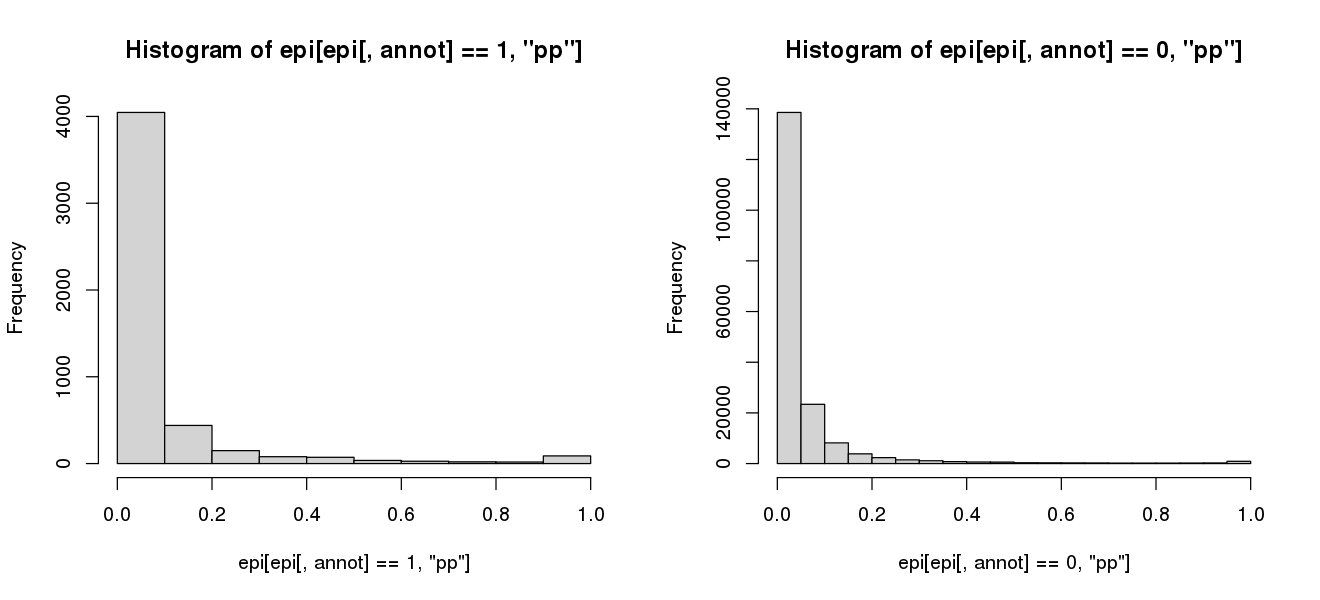


	Welch Two Sample t-test

data:  epi[epi[, annot] == 1, "pp"] and epi[epi[, annot] == 0, "pp"]
t = 13.042, df = 4580.6, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.02979294 0.04033412
sample estimates:
 mean of x  mean of y 
0.09334360 0.05828007 


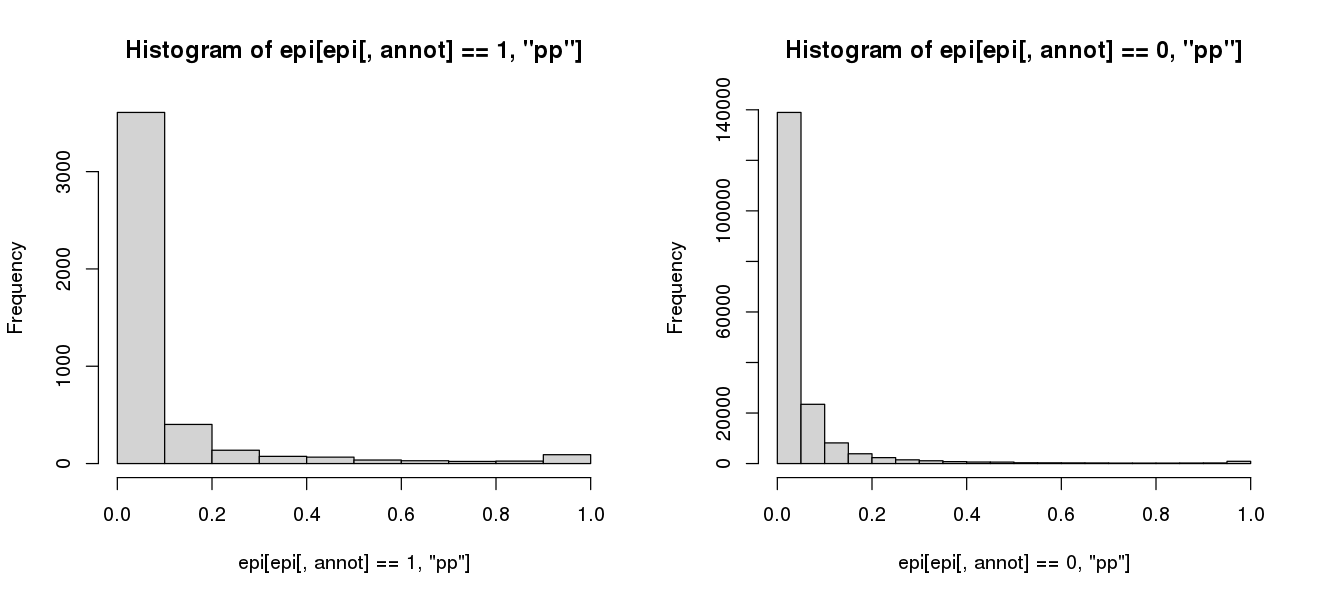

In [237]:
test_enrichment = function(epi, ints, cell, annot)
{
    ints$tr2type = paste(ints$transcript_id, ints$type)
    
    trids1 = unique(this[this[,annot] == 1, "tr2type"])
    trids2 = unique(this[this[,annot] == 0, "tr2type"])
    
    ints1  = ints[ints$tr2type %in% trids1 & ints$cell_specific == sub("^cell\\.", "", cell),]
    ints2  = ints[ints$tr2type %in% trids2 & ints$cell_specific == sub("^cell\\.", "", cell),]
    
    options(repr.plot.width = 11, repr.plot.height = 5)
    layout(matrix(1:2, nrow = 1, byrow = TRUE))
    hist(epi[epi[,annot] == 1, "pp"])
    hist(epi[epi[,annot] == 0, "pp"])
    
    return(t.test(epi[epi[,annot] == 1, "pp"], epi[epi[,annot] == 0, "pp"]))
    return(t.test(ints1$beta_int, ints2$beta_int))
    
}

test_enrichment(epi_gene, int_genes, "cell.cibersort.regular.cardiac_muscle", "epi.ipsc_epdc.enhancers")
test_enrichment(epi_gene, int_genes, "cell.cibersort.regular.smooth_muscle" , "epi.ipsc_cm.enhancers")
#test_enrichment(epi_gene, "cell.cibersort.regular.smooth_muscle" , "epi.ipsc_cm.enhancers", "epi.ipsc_epdc.enhancers")



	Welch Two Sample t-test

data:  this[this[, annot1] == 1, "pp"] and this[this[, annot2] == 1, "pp"]
t = 2.0138, df = 4889.2, p-value = 0.04408
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.0002301992 0.0171340434
sample estimates:
 mean of x  mean of y 
0.08446919 0.07578707 


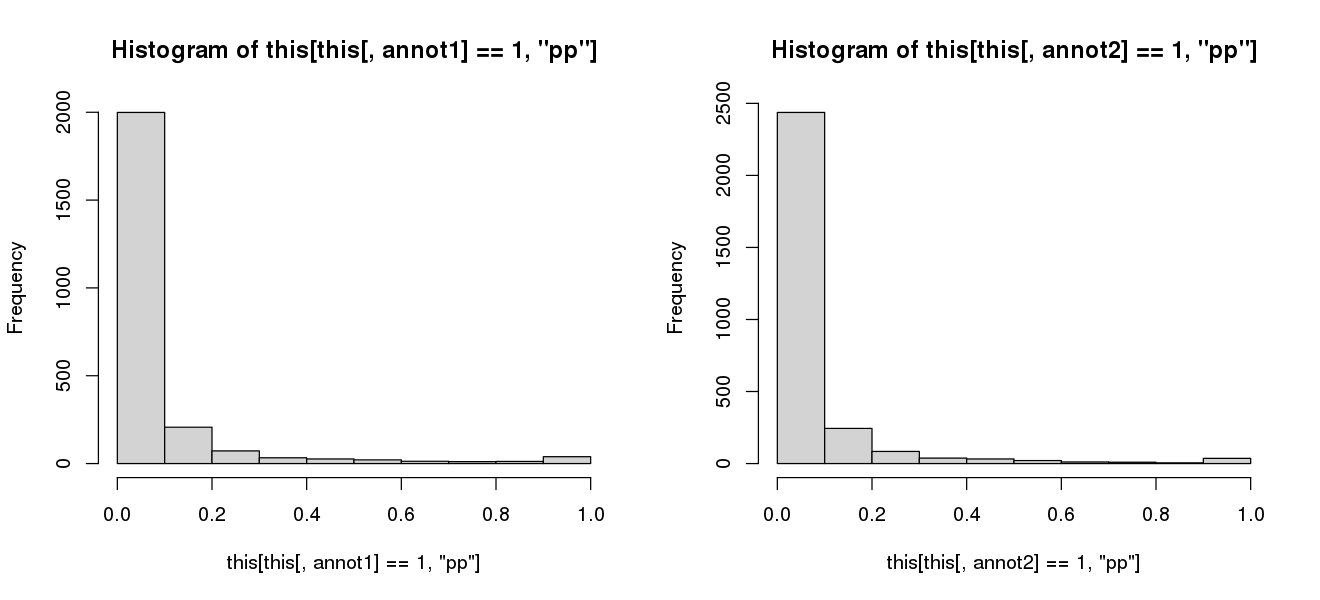

In [233]:
test_enrichment = function(epi, ints, cell, annot1, annot2)
{
    this         = epi[rowSums(epi[,c(annot1, annot2)]) == 1,]
    ints$tr2type = paste(ints$transcript_id, ints$type)
    
    trids1 = unique(this[this[,annot1] == 1, "tr2type"])
    trids2 = unique(this[this[,annot2] == 1, "tr2type"])
    
    ints1  = ints[ints$tr2type %in% trids1 & ints$cell_specific == sub("^cell\\.", "", cell),]
    ints2  = ints[ints$tr2type %in% trids2 & ints$cell_specific == sub("^cell\\.", "", cell),]
    
    options(repr.plot.width = 11, repr.plot.height = 5)
    layout(matrix(1:2, nrow = 1, byrow = TRUE))
    hist(this[this[,annot1] == 1, "pp"])
    hist(this[this[,annot2] == 1, "pp"])
    
    return(t.test(this[this[,annot1] == 1, "pp"], this[this[,annot2] == 1, "pp"]))
    return(t.test(ints1$beta_int, ints2$beta_int))
    
}

test_enrichment(epi_gene, int_genes, "cell.cibersort.regular.cardiac_muscle", "epi.ipsc_cm.enhancers", "epi.ipsc_epdc.enhancers")
#test_enrichment(epi_gene, "cell.cibersort.regular.smooth_muscle" , "epi.ipsc_cm.enhancers", "epi.ipsc_epdc.enhancers")


In [223]:
str(int_genes)

'data.frame':	271710 obs. of  38 variables:
 $ transcript_id : chr  "ENSG00000000457.14_7" "ENSG00000000460.17_7" "ENSG00000000971.16_4" "ENSG00000001036.14_5" ...
 $ gene_id       : chr  "ENSG00000000457.14_7" "ENSG00000000460.17_7" "ENSG00000000971.16_4" "ENSG00000001036.14_5" ...
 $ gene_name     : chr  "SCYL3" "C1orf112" "CFH" "FUCA2" ...
 $ gene_type     : chr  "protein_coding" "protein_coding" "protein_coding" "protein_coding" ...
 $ start         : int  169818772 169631245 196621173 143815949 53362139 41040684 41040684 24683489 24742292 46097726 ...
 $ end           : int  169863408 169823221 196716634 143832857 53481768 41067715 41067715 24743424 24799466 46114425 ...
 $ strand        : chr  "-" "+" "+" "-" ...
 $ chrom         : int  1 1 1 6 6 6 6 1 1 6 ...
 $ pos           : int  169860528 169653795 196357746 143927360 53377619 41098510 41222926 24731659 24759685 46134213 ...
 $ ref           : chr  "C" "A" "A" "G" ...
 $ alt           : chr  "A" "G" "G" "T" ...
 $ rsid      

In [203]:
str(epi_gene)

'data.frame':	188792 obs. of  34 variables:
 $ tr2type                              : chr  "ENSG00000000457.14_7 0" "ENSG00000000457.14_7 0" "ENSG00000000457.14_7 0" "ENSG00000000457.14_7 0" ...
 $ transcript_id                        : chr  "ENSG00000000457.14_7" "ENSG00000000457.14_7" "ENSG00000000457.14_7" "ENSG00000000457.14_7" ...
 $ gene_id                              : chr  "ENSG00000000457.14_7" "ENSG00000000457.14_7" "ENSG00000000457.14_7" "ENSG00000000457.14_7" ...
 $ gene_name                            : chr  "SCYL3" "SCYL3" "SCYL3" "SCYL3" ...
 $ type                                 : int  0 0 0 0 0 0 0 0 0 0 ...
 $ id                                   : chr  "VAR_1_169685640_CCAAA_C" "VAR_1_169685836_T_C" "VAR_1_169686322_T_C" "VAR_1_169687418_C_T" ...
 $ chrom                                : int  1 1 1 1 1 1 1 1 1 1 ...
 $ pos                                  : int  169685640 169685836 169686322 169687418 169689041 169689575 169690313 169690473 169690816 169692522 ...


In [182]:
t.test(epi_gene[(epi_gene[,"stage.ipsc_cvpc"] == 1) & (epi_gene[,"epi.ipsc_cvpc.narrowpeak"] == 1), "pp"],
       epi_gene[(epi_gene[,"stage.ipsc_cvpc"] == 1) & (epi_gene[,"epi.ipsc_cvpc.narrowpeak"] == 0), "pp"]
      )



	Welch Two Sample t-test

data:  epi_gene[(epi_gene[, "stage.ipsc_cvpc"] == 1) & (epi_gene[, "epi.ipsc_cvpc.narrowpeak"] == 1), "pp"] and epi_gene[(epi_gene[, "stage.ipsc_cvpc"] == 1) & (epi_gene[, "epi.ipsc_cvpc.narrowpeak"] == 0), "pp"]
t = 1.0245, df = 153.46, p-value = 0.3072
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.01584302  0.04997895
sample estimates:
 mean of x  mean of y 
0.07708768 0.06001971 


In [184]:
test = epi_gene

test$epi_adult.narrowpeak = unlist(lapply(1:nrow(test), function(ii)
{
    min(c(1, sum(test[ii, paste("epi", c("aorta.narrowpeak", "left_ventricle.narrowpeak", "right_ventricle.narrowpeak", "right_atrium.narrowpeak"), sep = ".")])))
}))

In [185]:
fisher.test(table(test[(test[,"stage.ipsc_cvpc"] == 1), c("epi.ipsc_cvpc.narrowpeak", "epi_adult.narrowpeak")]))
fisher.test(table(test[(test[,"stage.adult"    ] == 1), c("epi.ipsc_cvpc.narrowpeak", "epi_adult.narrowpeak")]))

table(test[(test[,"stage.ipsc_cvpc"] == 1), c("epi.ipsc_cvpc.narrowpeak", "epi_adult.narrowpeak")])
table(test[(test[,"stage.ipsc_cvpc"] == 0), c("epi.ipsc_cvpc.narrowpeak", "epi_adult.narrowpeak")])
table(test[(test[,"stage.adult"    ] == 1), c("epi.ipsc_cvpc.narrowpeak", "epi_adult.narrowpeak")])
table(test[(test[,"stage.adult"    ] == 0), c("epi.ipsc_cvpc.narrowpeak", "epi_adult.narrowpeak")])



	Fisher's Exact Test for Count Data

data:  table(test[(test[, "stage.ipsc_cvpc"] == 1), c("epi.ipsc_cvpc.narrowpeak", "epi_adult.narrowpeak")])
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  9.936271 26.965899
sample estimates:
odds ratio 
  16.26441 



	Fisher's Exact Test for Count Data

data:  table(test[(test[, "stage.adult"] == 1), c("epi.ipsc_cvpc.narrowpeak", "epi_adult.narrowpeak")])
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 10.39061 15.95622
sample estimates:
odds ratio 
  12.86403 


                        epi_adult.narrowpeak
epi.ipsc_cvpc.narrowpeak   0   1
                       0 679  39
                       1  67  63

                        epi_adult.narrowpeak
epi.ipsc_cvpc.narrowpeak      0      1
                       0 144802   9300
                       1  18605  15237

                        epi_adult.narrowpeak
epi.ipsc_cvpc.narrowpeak    0    1
                       0 3164  194
                       1  385  304

                        epi_adult.narrowpeak
epi.ipsc_cvpc.narrowpeak      0      1
                       0 142317   9145
                       1  18287  14996

[1] 1.6

[1] 2.089747

In [169]:
715/2987
149/633
56/10
256/89

[1] 0.2393706

[1] 0.235387

[1] 5.6

[1] 2.876404

In [170]:
this = epi_gene[(epi_gene[,"stage.ipsc_cvpc"] == 1 | epi_gene[,"stage.adult"    ] == 1) & (epi_gene[,"epi.ipsc_cvpc.narrowpeak"] == 1 | epi_gene[,"epi.left_ventricle.narrowpeak"] == 1),]

table(this[this[,"stage.ipsc_cvpc"] == 1,c("epi.ipsc_cvpc.narrowpeak", "epi.left_ventricle.narrowpeak")])
table(this[this[,"stage.adult"    ] == 1,c("epi.ipsc_cvpc.narrowpeak", "epi.left_ventricle.narrowpeak")])



                        epi.left_ventricle.narrowpeak
epi.ipsc_cvpc.narrowpeak  0  1
                       0  0 16
                       1 80 50

                        epi.left_ventricle.narrowpeak
epi.ipsc_cvpc.narrowpeak   0   1
                       0   0 118
                       1 462 227

In [163]:
149/56
715/256

[1] 2.660714

[1] 2.792969

In [144]:

t.test(epi_gene[epi_gene[,"stage.ipsc_cvpc"] == 1 & epi_gene[,"epi.ipsc_cvpc.summit"] == 1, "pp"], epi_gene[epi_gene[,"stage.ipsc_cvpc"] == 1 & epi_gene[,"epi.ipsc_cvpc.summit"] == 0, "pp"])
t.test(epi_gene[epi_gene[,"stage.adult"    ] == 1 & epi_gene[,"epi.ipsc_cvpc.summit"] == 1, "pp"], epi_gene[epi_gene[,"stage.adult"    ] == 1 & epi_gene[,"epi.ipsc_cvpc.summit"] == 0, "pp"])



	Welch Two Sample t-test

data:  epi_gene[epi_gene[, "stage.ipsc_cvpc"] == 1 & epi_gene[, "epi.ipsc_cvpc.summit"] == 1, "pp"] and epi_gene[epi_gene[, "stage.ipsc_cvpc"] == 1 & epi_gene[, "epi.ipsc_cvpc.summit"] == 0, "pp"]
t = 1.0509, df = 281.26, p-value = 0.2942
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.01178569  0.03878311
sample estimates:
 mean of x  mean of y 
0.07287172 0.05937301 



	Welch Two Sample t-test

data:  epi_gene[epi_gene[, "stage.adult"] == 1 & epi_gene[, "epi.ipsc_cvpc.summit"] == 1, "pp"] and epi_gene[epi_gene[, "stage.adult"] == 1 & epi_gene[, "epi.ipsc_cvpc.summit"] == 0, "pp"]
t = 7.2735, df = 1278.6, p-value = 6.088e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.04371318 0.07600338
sample estimates:
 mean of x  mean of y 
0.14953575 0.08967747 


In [161]:
str(epi_gene)

'data.frame':	188792 obs. of  115 variables:
 $ tr2type                              : chr  "ENSG00000000457.14_7 0" "ENSG00000000457.14_7 0" "ENSG00000000457.14_7 0" "ENSG00000000457.14_7 0" ...
 $ transcript_id                        : chr  "ENSG00000000457.14_7" "ENSG00000000457.14_7" "ENSG00000000457.14_7" "ENSG00000000457.14_7" ...
 $ gene_id                              : chr  "ENSG00000000457.14_7" "ENSG00000000457.14_7" "ENSG00000000457.14_7" "ENSG00000000457.14_7" ...
 $ gene_name                            : chr  "SCYL3" "SCYL3" "SCYL3" "SCYL3" ...
 $ type                                 : int  0 0 0 0 0 0 0 0 0 0 ...
 $ id                                   : chr  "VAR_1_169685640_CCAAA_C" "VAR_1_169685836_T_C" "VAR_1_169686322_T_C" "VAR_1_169687418_C_T" ...
 $ chrom                                : int  1 1 1 1 1 1 1 1 1 1 ...
 $ pos                                  : int  169685640 169685836 169686322 169687418 169689041 169689575 169690313 169690473 169690816 169692522 ...

In [148]:
#epi_gene2 = aggregate(. ~ transcript_id, data = epi_gene[epi_gene$pp > 0.1,c(2, 13:ncol(epi_gene))], FUN = max)
epi_gene2 = epi_gene[epi_gene$pp > 0.1,]

In [149]:
mean(epi_gene2[,"stage.ipsc_cvpc"])
mean(epi_gene2[,"stage.adult"    ])
mean(epi_gene2[,"epi.ipsc_cvpc.summit"])

mean(epi_gene2[,"stage.ipsc_cvpc"]) * mean(epi_gene2[,"epi.ipsc_cvpc.summit"])
mean(epi_gene2[,"stage.adult"    ]) * mean(epi_gene2[,"epi.ipsc_cvpc.summit"])


nrow(epi_gene2[epi_gene2[,"stage.ipsc_cvpc"] == 1 & epi_gene2[,"epi.ipsc_cvpc.summit"] == 1,]) / nrow(epi_gene2)
nrow(epi_gene2[epi_gene2[,"stage.adult"    ] == 1 & epi_gene2[,"epi.ipsc_cvpc.summit"] == 1,]) / nrow(epi_gene2)


[1] 0.004125159

[1] 0.03962786

[1] 0.3453724

[1] 0.001424716

[1] 0.01368637

[1] 0.001053232

[1] 0.01386756

In [150]:
fisher.test(table(epi_gene2[,c("stage.ipsc_cvpc", "epi.ipsc_cvpc.summit")]))
fisher.test(table(epi_gene2[,c("stage.adult"    , "epi.ipsc_cvpc.summit")]))



	Fisher's Exact Test for Count Data

data:  table(epi_gene2[, c("stage.ipsc_cvpc", "epi.ipsc_cvpc.summit")])
p-value = 0.08133
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.389842 1.045567
sample estimates:
odds ratio 
 0.6488007 



	Fisher's Exact Test for Count Data

data:  table(epi_gene2[, c("stage.adult", "epi.ipsc_cvpc.summit")])
p-value = 0.7752
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.8853088 1.1763133
sample estimates:
odds ratio 
  1.021229 


In [138]:
mean(epi_gene[,"stage.ipsc_cvpc"])
mean(epi_gene[,"stage.adult"    ])
mean(epi_gene[,"epi.ipsc_cvpc.summit"])

mean(epi_gene[,"stage.ipsc_cvpc"]) * mean(epi_gene[,"epi.ipsc_cvpc.summit"])
mean(epi_gene[,"stage.adult"    ]) * mean(epi_gene[,"epi.ipsc_cvpc.summit"])


nrow(epi_gene[epi_gene[,"stage.ipsc_cvpc"] == 1 & epi_gene[,"epi.ipsc_cvpc.summit"] == 1,]) / nrow(epi_gene)
nrow(epi_gene[epi_gene[,"stage.adult"    ] == 1 & epi_gene[,"epi.ipsc_cvpc.summit"] == 1,]) / nrow(epi_gene)


[1] 0.004491716

[1] 0.02143629

[1] 0.2556093

[1] 0.001148125

[1] 0.005479316

[1] 0.001085851

[1] 0.005143226

In [139]:
fisher.test(table(epi_gene[,c("stage.ipsc_cvpc", "epi.ipsc_cvpc.summit")]))
fisher.test(table(epi_gene[,c("stage.adult"    , "epi.ipsc_cvpc.summit")]))



	Fisher's Exact Test for Count Data

data:  table(epi_gene[, c("stage.ipsc_cvpc", "epi.ipsc_cvpc.summit")])
p-value = 0.3644
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.7889598 1.0881991
sample estimates:
odds ratio 
 0.9281638 



	Fisher's Exact Test for Count Data

data:  table(epi_gene[, c("stage.adult", "epi.ipsc_cvpc.summit")])
p-value = 0.0207
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.8522482 0.9873659
sample estimates:
odds ratio 
 0.9176435 


In [187]:
as.matrix(colMeans(epi_gene[,13:ncol(epi_gene)]))

tissue.arteria,0.0347896097
tissue.arteria_aorta,0.0233643375
tissue.arteria_coronary,0.0049366499
cell.cibersort.regular.cardiac_muscle,0.0595046400
cell.cibersort.regular.cardiac_neuron,0.0666447731
cell.cibersort.regular.endocardial,0.0176755371
cell.cibersort.regular.endothelial,0.0100375016
cell.cibersort.regular.fibroblast,0.0304144243
cell.cibersort.regular.immune,0.0293126827
cell.cibersort.regular.myofibroblast,0.0010328827
cell.cibersort.regular.smooth_muscle,0.0570680961


In [125]:
nrow(epi_gene[epi_gene[,"stage.ipsc_cvpc"] == 1 & epi_gene[,"epi.fetal_heart.1_TssA"] == 1,]) / nrow(epi_gene[epi_gene[,"stage.ipsc_cvpc"] == 1 | epi_gene[,"epi.fetal_heart.1_TssA"] == 1,])
nrow(epi_gene[epi_gene[,"stage.adult"    ] == 1 & epi_gene[,"epi.fetal_heart.1_TssA"] == 1,]) / nrow(epi_gene[epi_gene[,"stage.adult"    ] == 1 | epi_gene[,"epi.fetal_heart.1_TssA"] == 1,])


[1] 0.005860954

[1] 0.01275858

In [128]:
fisher.test(matrix(c(46, 802, 200, 3847), nrow = 2, byrow = TRUE))


	Fisher's Exact Test for Count Data

data:  matrix(c(46, 802, 200, 3847), nrow = 2, byrow = TRUE)
p-value = 0.5456
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.7755388 1.5419871
sample estimates:
odds ratio 
  1.103254 


# Examples

In [8]:
metadata   =              fread("pipeline/3.1.covariates/metadata.txt"     , sep = "\t", header = TRUE , data.table = FALSE)
covariates = add_rownames(fread("pipeline/3.1.covariates/covariates.txt"   , sep = "\t", header = TRUE , data.table = FALSE))
int_list   = readLines         ("pipeline/3.2.eqtls/vars/cardiac_eqtls.gene.txt")
int2_list  = readLines         ("pipeline/3.2.eqtls/vars/covariates_to_interaction.txt")
covariates = covariates[,unique(c(int_list, int2_list))]
gene_tpm   = add_rownames(fread("pipeline/1.2.expression/tpm_gene.normalized.txt"   , sep = "\t", header = TRUE , data.table = FALSE))
isof_tpm   = add_rownames(fread("pipeline/1.2.expression/tpm_isoform.normalized.txt", sep = "\t", header = TRUE , data.table = FALSE))
isof_use   = add_rownames(fread("pipeline/1.2.expression/use_isoform.normalized.txt", sep = "\t", header = TRUE , data.table = FALSE))


## eQTL

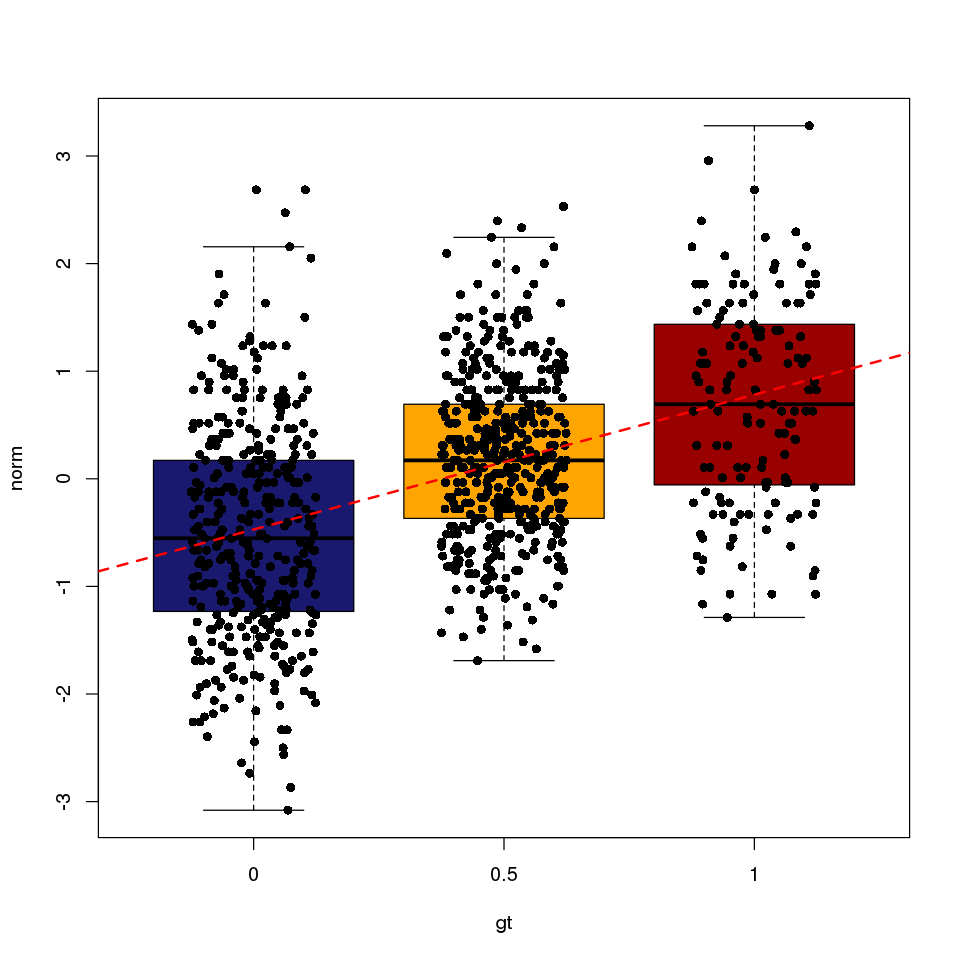

In [9]:
plot_eqtl = function(transcript_id, source, id, covariates, metadata)
{
    expdata  = add_rownames(fread(paste("pipeline/1.2.expression", source, paste(           transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE))
    gtdata   = add_rownames(fread(paste("pipeline/1.3.genotype"  , source, paste("gt_data", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE))
    gtinfo   =              fread(paste("pipeline/1.3.genotype"  , source, paste("gt_info", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE)
    gtdata   = data.frame(wgs_id = colnames(gtdata), gt = as.numeric(gtdata[id,]))
    toplot   = add_rownames(merge(covariates, metadata, by.x = "row.names", by.y = "run"))
    toplot   = merge(toplot, expdata, by = "row.names")
    toplot   = merge(toplot, gtdata , by = "wgs_id"   )
    toplot$x = toplot$gt * 2 + 1
    
    boxplot(norm ~ gt, data = toplot, outline = FALSE, col = c("#191970", "#ffa500", "#990000"))
    points (x = jitter(toplot$x, amount = 0.25), y = toplot$norm, pch = 16)
    abline (lm(norm ~ x, data = toplot), lty = "dashed", col = "#ff0000", lwd = 2)
}

plot_eqtl("ENSG00000105193.9_5", "tpm_gene", "VAR_19_39926825_T_C", covariates, metadata)

## Cell type association

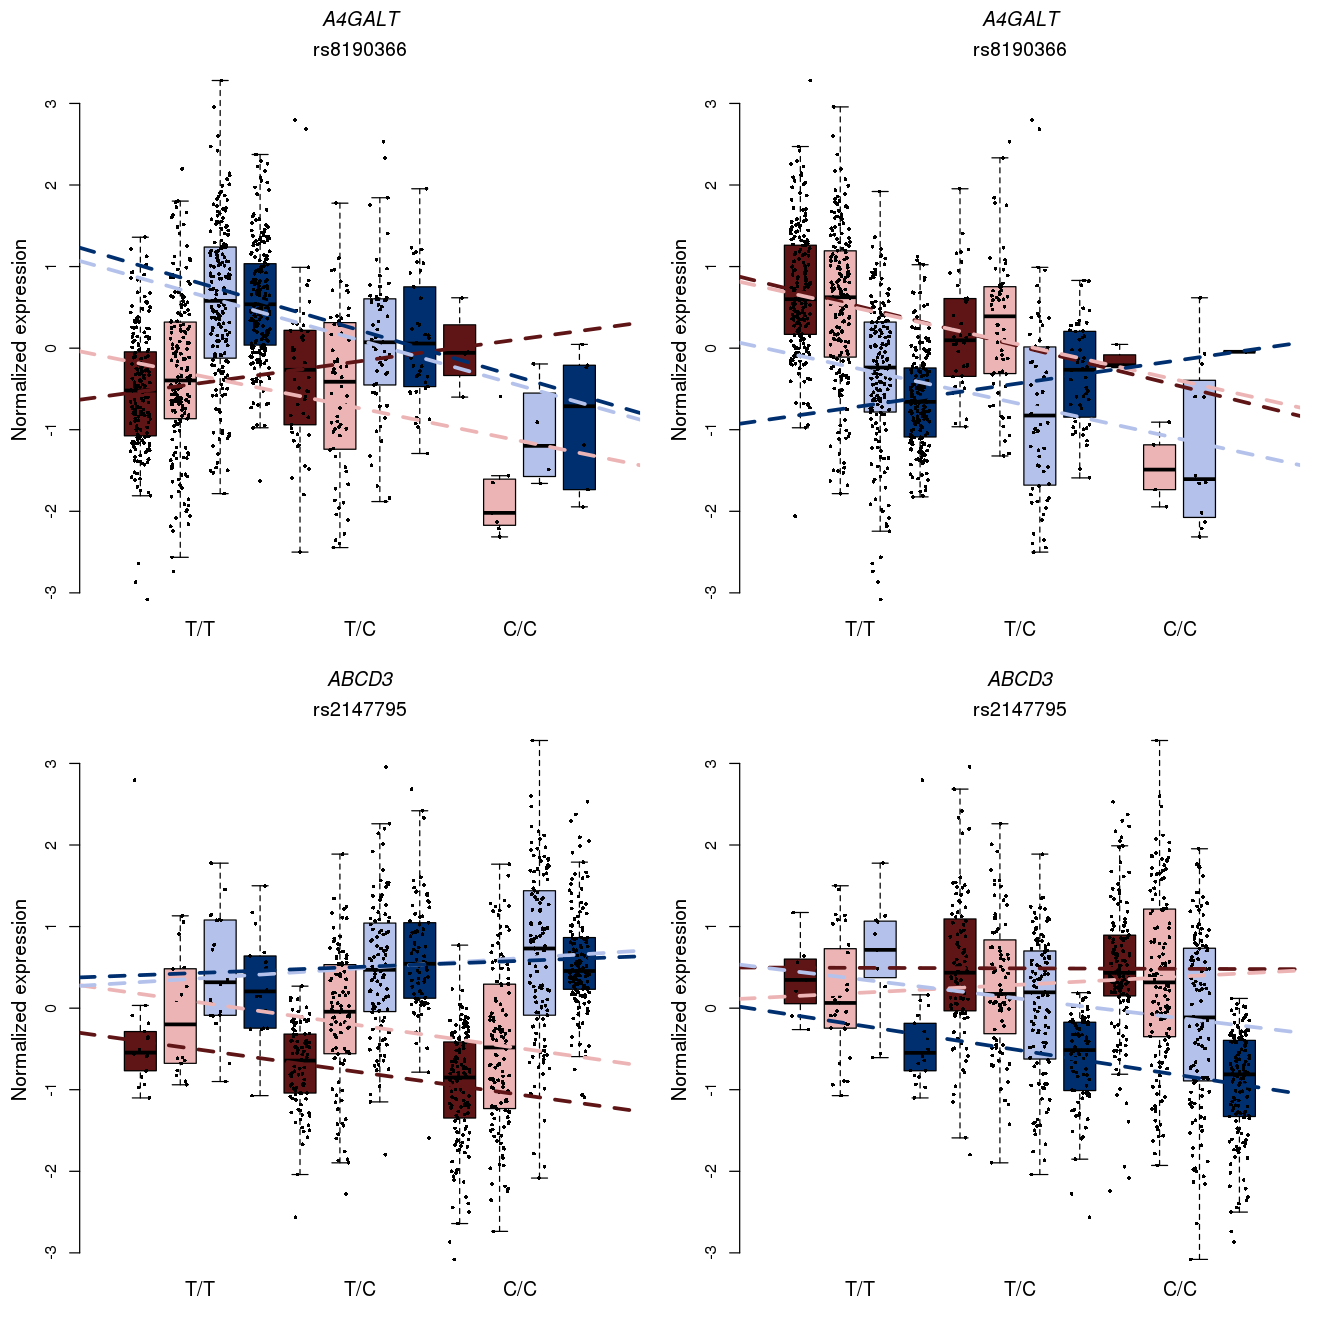

In [220]:
plot_celltype_quantile = function(transcript_id, source, id, cell, covariates, metadata, eqtls, quantiles = 4)
{
    expdata  = add_rownames(fread(paste("pipeline/1.2.expression", source, paste(           transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE))
    gtdata   = add_rownames(fread(paste("pipeline/1.3.genotype"  , source, paste("gt_data", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE))
    gtinfo   =              fread(paste("pipeline/1.3.genotype"  , source, paste("gt_info", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE)
    gtdata   = data.frame(wgs_id = colnames(gtdata), gt = as.numeric(gtdata[id,]))
    toplot   = add_rownames(merge(covariates, metadata, by.x = "row.names", by.y = "run"))
    toplot   = merge(toplot, expdata, by = "row.names")
    toplot   = merge(toplot, gtdata , by = "wgs_id"   )
    gtinfo   = gtinfo[gtinfo$id == id,]
    
    gt2color = data.frame(gt = c(0, 0.5, 1), color = c("#191970", "#ffa500", "#990000"))
    
    toplot$cell     = toplot[,cell]
    toplot          = toplot[order(toplot$cell),]
    quantiles       = round((1:quantiles) / quantiles * nrow(toplot), digits = 0)
    toplot$quantile = 0
    
    for(ii in 1:length(quantiles))
    {
        x1 = quantiles[[ii]]
        x0 = 1
        if (ii > 1){x0 = quantiles[[ii - 1]] + 1}
        
        toplot[x0:x1, "quantile"] = ii
    }
    
    toplot$gt_quantile = paste(toplot$gt, toplot$quantile)
    tobox              = aggregate(norm ~ quantile + gt + gt_quantile, data = toplot, mean)
    tobox              = tobox[order(tobox$gt, tobox$quantile),]
    tobox$x            = 1:nrow(tobox)
    toplot             = merge(toplot, tobox[,c("gt_quantile", "x")])
    quantile2color     = data.frame(quantile = sort(unique(toplot$quantile)), color = diverging_hcl(n = length(unique(toplot$quantile)), palette = "Blue-Red 3", rev = TRUE))
    #return(tobox)
    #
    #boxplot(norm ~ quantile + gt, data = toplot, outline = FALSE, col = rep(quantile2color$color, 3))
    #
    #return(aggregate(norm ~ quantile + gt + x, data = toplot, mean))
    par(mar = c(2,4,3,1))
    plot(1,1, type = "n", xlim = c(0,max(toplot$x + 1)), ylim = range(toplot$norm), axes = FALSE, xlab = "", ylab = "")
    axis(2)
    
    boxplot(norm ~ quantile + gt, data = toplot, outline = FALSE, col = rep(quantile2color$color, 3), add = TRUE, at = tobox$x, axes = FALSE)
    points (x = jitter(toplot$x, amount = 0.25), y = toplot$norm, pch = 16, cex = 0.5)
    
    invisible(lapply(1:nrow(quantile2color), function(ii)
    {
        this = toplot[toplot$quantile == quantile2color[ii, "quantile"],]
        
        abline (lm(norm ~ x, data = this), lty = "dashed", col = quantile2color[ii, "color"], lwd = 3)
    }))
    
    gt1       = gtinfo[1, "ref" ]
    gt2       = gtinfo[1, "alt" ]
    rsid      = gtinfo[1, "rsid"]
    this_eqtl = eqtls[eqtls$transcript_id == transcript_id & eqtls$id == id, ]
    gene      = unique(this_eqtl[, "gene_name"])
    gts       = c(paste(gt1, gt1, sep = "/"), paste(gt1, gt2, sep = "/"), paste(gt2, gt2, sep = "/"))
    
    mtext(gts                    , side = 1, line = 0  , at = aggregate(x ~ gt, data = tobox, FUN = mean)$x)
    mtext(gene                   , side = 3, line = 1.5, font = 3)
    mtext(rsid                   , side = 3, line = 0  )
    mtext("Normalized expression", side = 2, line = 2.5)
}

toplot = int_genes[int_genes$interaction == "cibersort.regular.cardiac_muscle" & int_genes$int_signif == TRUE & int_genes$beta > 0 & int_genes$beta_int < 0, ]
toplot = toplot[order(toplot$pval_int),]

options(repr.plot.width = 11, repr.plot.height = 11)
layout(matrix(1:4, nrow = 2, byrow = TRUE))

#invisible(lapply(1:8, function(ii){try(plot_celltype_quantile(toplot[ii, "transcript_id"], "tpm_gene", toplot[ii, "id"], "cibersort.regular.cardiac_muscle", covariates, metadata, eqtl_genes))}))

plot_celltype_quantile("ENSG00000128274.17_6", "tpm_gene", "VAR_22_43045537_T_C", "cibersort.regular.cardiac_muscle", covariates, metadata, eqtl_genes)
plot_celltype_quantile("ENSG00000128274.17_6", "tpm_gene", "VAR_22_43045537_T_C", "cibersort.regular.smooth_muscle" , covariates, metadata, eqtl_genes)
plot_celltype_quantile("ENSG00000117528.14_6", "tpm_gene", "VAR_1_94948133_T_C" , "cibersort.regular.cardiac_muscle", covariates, metadata, eqtl_genes)
plot_celltype_quantile("ENSG00000117528.14_6", "tpm_gene", "VAR_1_94948133_T_C" , "cibersort.regular.smooth_muscle" , covariates, metadata, eqtl_genes)



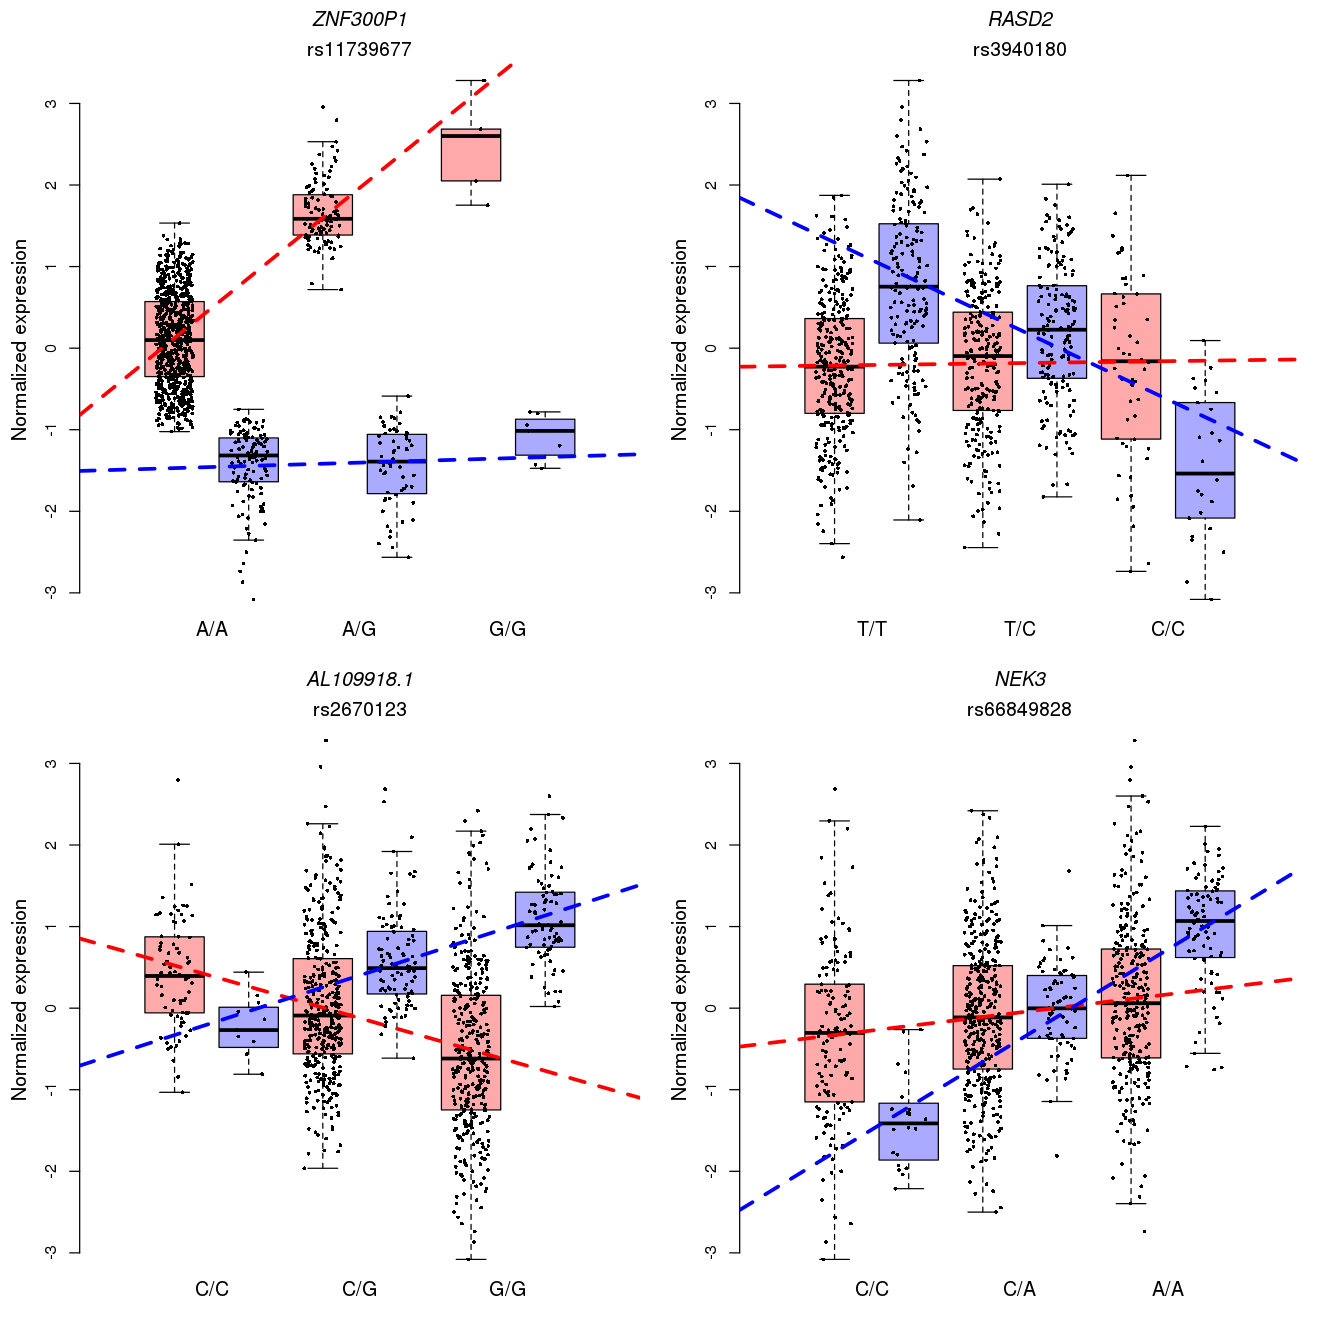

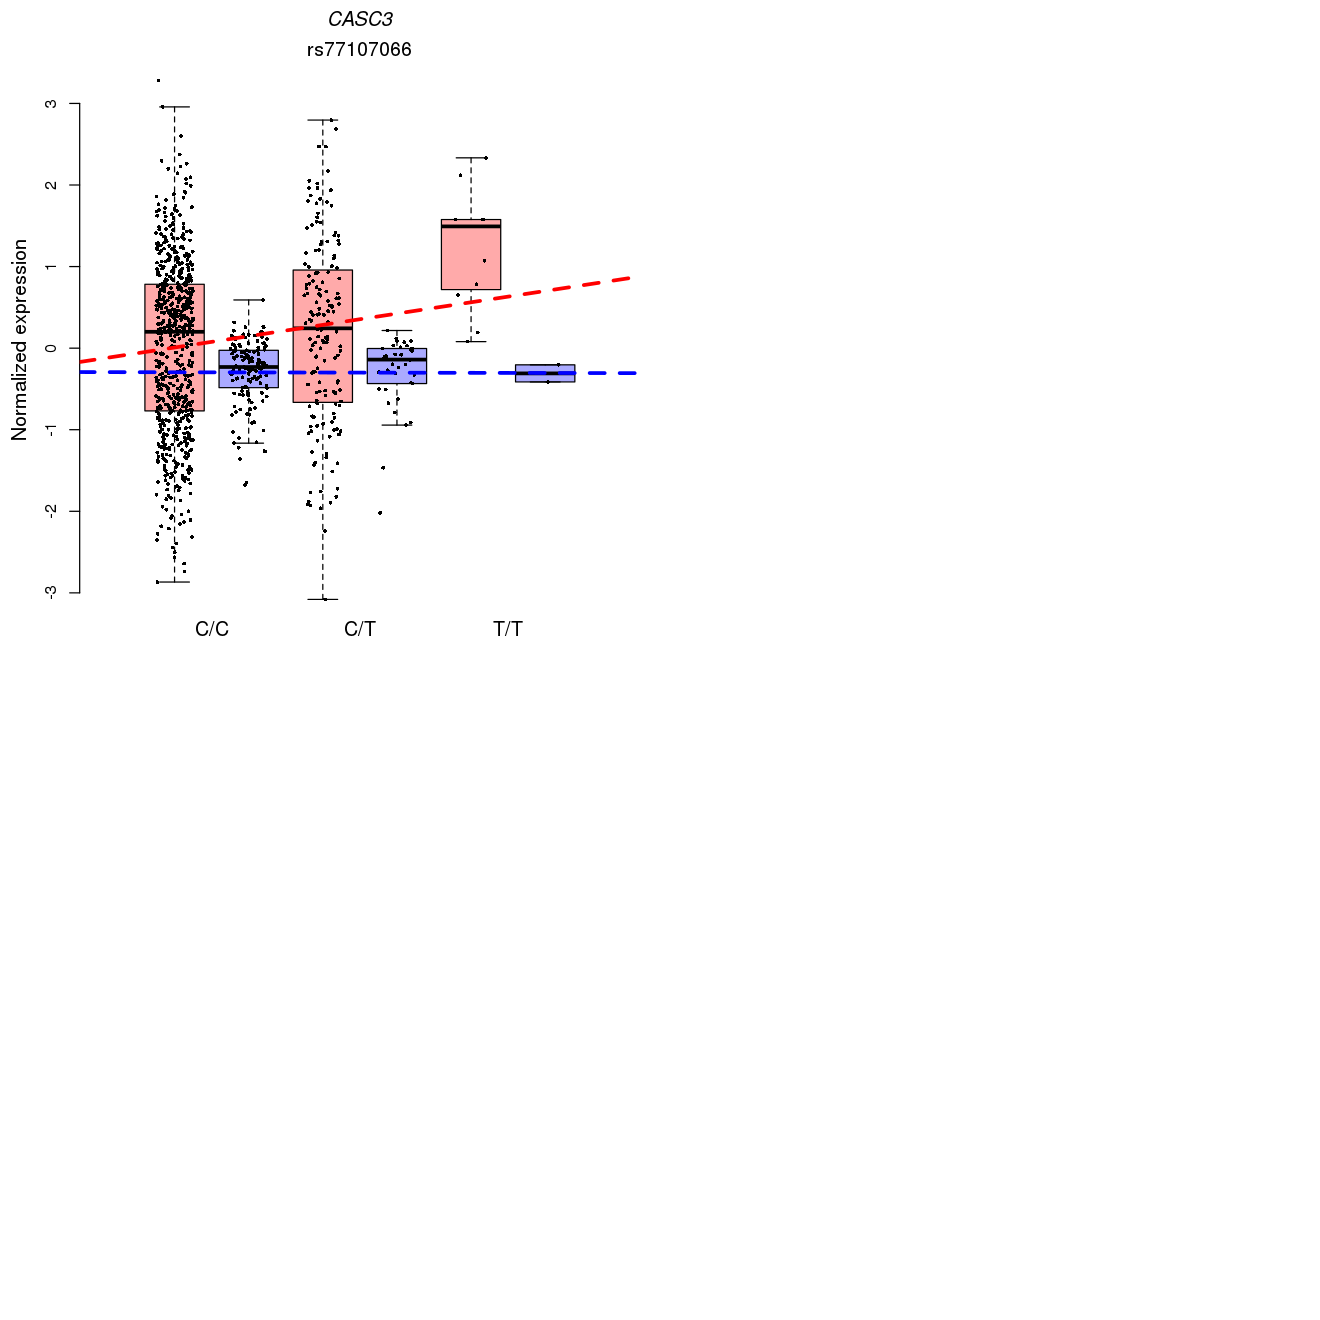

In [11]:
plot_celltype_numeric = function(transcript_id, source, id, cell, covariates, metadata, eqtls)
{
    expdata  = add_rownames(fread(paste("pipeline/1.2.expression", source, paste(           transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE))
    gtdata   = add_rownames(fread(paste("pipeline/1.3.genotype"  , source, paste("gt_data", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE))
    gtinfo   =              fread(paste("pipeline/1.3.genotype"  , source, paste("gt_info", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE)
    gtdata   = data.frame(wgs_id = colnames(gtdata), gt = as.numeric(gtdata[id,]))
    toplot   = add_rownames(merge(covariates, metadata, by.x = "row.names", by.y = "run"))
    toplot   = merge(toplot, expdata, by = "row.names")
    toplot   = merge(toplot, gtdata , by = "wgs_id"   )
    gtinfo   = gtinfo[gtinfo$id == id,]
    
    gt2color = data.frame(gt = c(0, 0.5, 1), color = c("#191970", "#ffa500", "#990000"))
    
    toplot$cell = toplot[,cell]
    toplot$x    = (toplot$gt * 4 + 1) + toplot$cell
    
    par(mar = c(2,4,3,1))
    plot(1,1, type = "n", xlim = c(0,7), ylim = range(toplot$norm), axes = FALSE, xlab = "", ylab = "")
    axis(2)
    
    boxplot(norm ~ cell + gt, data = toplot, outline = FALSE, col = rep(c("#ffaaaa", "#aaaaff"), 3), add = TRUE, at = (1:6), axes = FALSE)
    points (x = jitter(toplot$x, amount = 0.25), y = toplot$norm, pch = 16, cex = 0.5)
    abline (lm(norm ~ x, data = toplot[toplot$cell == 0,]), lty = "dashed", col = "#ff0000", lwd = 3)
    abline (lm(norm ~ x, data = toplot[toplot$cell == 1,]), lty = "dashed", col = "#0000ff", lwd = 3)
    
    gt1  = gtinfo[1, "ref" ]
    gt2  = gtinfo[1, "alt" ]
    rsid = gtinfo[1, "rsid"]
    gene = unique(eqtls[eqtls$transcript_id == transcript_id & eqtls$id == id, "gene_name"])
    gts  = c(paste(gt1, gt1, sep = "/"), paste(gt1, gt2, sep = "/"), paste(gt2, gt2, sep = "/"))
    
    mtext(gts                    , side = 1, line = 0  , at = c(1.5, 3.5, 5.5))
    mtext(gene                   , side = 3, line = 1.5, font = 3)
    mtext(rsid                   , side = 3, line = 0  )
    mtext("Normalized expression", side = 2, line = 2.5)
}

toplot = int_genes[int_genes$interaction == "ipsc_cvpc" & int_genes$int_signif == TRUE, ]
toplot = toplot[order(toplot$pval_int),]

options(repr.plot.width = 11, repr.plot.height = 11)
layout(matrix(1:4, nrow = 2, byrow = TRUE))

#invisible(lapply(1:32, function(ii){try(plot_celltype_numeric(toplot[ii, "transcript_id"], "tpm_gene", toplot[ii, "id"], "ipsc_cvpc", covariates, metadata, eqtl_genes))}))

plot_celltype_numeric("ENSG00000197083.11_6", "tpm_gene", "VAR_5_150294883_A_G", "ipsc_cvpc", covariates, metadata, eqtl_genes)
plot_celltype_numeric("ENSG00000100302.7_4" , "tpm_gene", "VAR_22_35932473_T_C", "arteria"  , covariates, metadata, eqtl_genes)
plot_celltype_numeric("ENSG00000216775.3_6" , "tpm_gene", "VAR_6_52529714_C_G" , "ipsc_cvpc", covariates, metadata, eqtl_genes)
plot_celltype_numeric("ENSG00000136098.17_6", "tpm_gene", "VAR_13_52714837_C_A", "ipsc_cvpc", covariates, metadata, eqtl_genes)
plot_celltype_numeric("ENSG00000108349.17_5", "tpm_gene", "VAR_17_38553174_C_T", "ipsc_cvpc", covariates, metadata, eqtl_genes)





In [15]:
a = int_genes[int_genes$transcript_id == "ENSG00000216775.3_6",]

fwrite(a, "pipeline/3.2.eqtls/eqtls/TMP.cardiac_eqtls.gene.interactions.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

In [243]:
int_isoforms[ int_isoforms$gene_name == "CDKN1A" & int_isoforms$int_signif == TRUE,]

,transcript_id,gene_id,gene_name,gene_type,start,end,strand,chrom,pos,ref,⋯,beta_1,se_1,pval_1,distance,qval_int,qval_1,qval_0,int_signif,cell_specific,stage_specific
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>
135139,ENST00000244741.10_2,ENSG00000124762.14_4,CDKN1A,protein_coding,36646491,36655109,+,6,36646788,A,⋯,0.3292768,0.1183496,0.005980773,297,4.639427e-06,1,1,TRUE,,
